In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
% matplotlib inline
plt.style.use("ggplot")
os.getcwd()
os.chdir('/Users/caden/Desktop/yelp_project/data')

In [2]:
df = pd.read_csv('last_2_year_restaurant_reviews_Las_Vegas.csv')

# 1. Cluster the review text

In [3]:
documents = df['text'].copy()
target = df['stars'].apply(lambda x: 'perfect' if x == 5 else 'imperfect')

In [4]:
target.value_counts()

perfect      588327
imperfect    548031
Name: stars, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
documents_train, documents_test, target_train, target_test = train_test_split(documents, target, test_size = 0.3, random_state = 0)
documents_train = documents_train.reset_index(drop = True)
documents_test = documents_test.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
target_test = target_test.reset_index(drop = True)

# 2. NLP process

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [7]:
vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'), max_features = 2000)
train_vector = vectorizer.fit_transform(documents_train)
test_vector = vectorizer.transform(documents_test)

In [8]:
# mapping from words to feature space
vectorizer.vocabulary_

{'vegas': 1885,
 'looking': 992,
 'something': 1617,
 'quick': 1368,
 'cheap': 313,
 'tasty': 1745,
 'place': 1280,
 'three': 1780,
 'husband': 866,
 'really': 1389,
 'enjoyed': 583,
 'good': 763,
 'food': 694,
 'great': 774,
 'price': 1333,
 'highly': 835,
 'recommend': 1400,
 'started': 1669,
 'treatment': 1830,
 'hair': 794,
 'two': 1850,
 'areas': 104,
 'super': 1714,
 'excited': 614,
 'finally': 667,
 'free': 704,
 'life': 963,
 'least': 952,
 'much': 1110,
 'less': 958,
 'informed': 889,
 'would': 1980,
 'maybe': 1041,
 'need': 1127,
 'touch': 1816,
 'staff': 1660,
 'always': 72,
 'nice': 1138,
 'come': 373,
 'appointments': 100,
 'every': 604,
 'appointment': 99,
 'running': 1467,
 'behind': 181,
 '15': 7,
 '30': 21,
 'minutes': 1084,
 'satisfied': 1490,
 'personal': 1259,
 'location': 985,
 'work': 1969,
 'looked': 991,
 'making': 1021,
 'first': 675,
 'final': 666,
 'returning': 1440,
 'concerns': 392,
 'never': 1135,
 'said': 1473,
 'anything': 86,
 'still': 1684,
 'left': 95

# 3. Cluster with K-means

In [45]:
from sklearn.cluster import KMeans
kmeans = KMeans()
kmeans.fit(train_vector)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
print('cluster centers: ')
print(kmeans.cluster_centers_)

cluster centers: 
[[0.0017773  0.00536732 0.00288692 ... 0.00079895 0.00166212 0.00085407]
 [0.00055354 0.00520874 0.0014826  ... 0.00172164 0.00412469 0.00035483]
 [0.00229343 0.00657429 0.00114835 ... 0.00213041 0.00577659 0.00112079]
 ...
 [0.00232755 0.00656903 0.00160222 ... 0.00417248 0.00751679 0.00065176]
 [0.00168332 0.00601325 0.00153903 ... 0.00208585 0.00484825 0.00071504]
 [0.00572695 0.01545745 0.00394316 ... 0.00012262 0.00036074 0.00469161]]


### inspect the centroid and map vectors back to word space

In [50]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
features = vectorizer.get_feature_names()
for num, centroid in enumerate(top_centroids):
    print('%d: %s' %(num, ','.join(features[i] for i in centroid)))

0: place,best,time,vegas,amazing,recommend,love,staff,friendly,get
1: always,love,place,great,service,food,friendly,staff,good,time
2: pizza,crust,good,place,great,cheese,slice,order,ordered,best
3: room,hotel,stay,rooms,stayed,pool,strip,casino,check,nice
4: great,service,place,food,friendly,amazing,staff,definitely,back,awesome
5: good,chicken,ordered,place,delicious,like,food,really,burger,try
6: food,good,service,place,restaurant,amazing,great,vegas,back,delicious
7: us,get,car,said,would,told,time,service,back,one


### inspect the ratings of each cluster

In [56]:
# find which cluster each review belongs to
assign_cluster = kmeans.transform(train_vector).argmin(axis = 1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(assign_cluster.shape[0])[assign_cluster == i]
    sample = np.random.choice(cluster, 1, replace = False)
    print('cluster %d:' %i)
    print('%s' %df.loc[sample]['stars'])

cluster 0:
275517    5
Name: stars, dtype: int64
cluster 1:
419893    1
Name: stars, dtype: int64
cluster 2:
672395    5
Name: stars, dtype: int64
cluster 3:
157545    5
Name: stars, dtype: int64
cluster 4:
33058    4
Name: stars, dtype: int64
cluster 5:
764964    2
Name: stars, dtype: int64
cluster 6:
419722    5
Name: stars, dtype: int64
cluster 7:
52573    5
Name: stars, dtype: int64


# 4. Use PCA to reduce dimensionality

### Standardize the vector before PCA

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train_vector.todense())
x_test_scaled = scaler.transform(test_vector.todense())

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
train_compoments = pca.fit_transform(x_train_scaled)
test_compoments = pca.transform(x_test_scaled)

In [10]:
pca.explained_variance_

array([8.10397535, 6.31509805, 4.86279102, 3.56212317, 3.47748602,
       3.35990417, 2.99522684, 2.91075164, 2.8373902 , 2.81938417,
       2.69815574, 2.59091126, 2.5590859 , 2.46824433, 2.41775189,
       2.39526418, 2.29537016, 2.27506675, 2.24284199, 2.2148752 ,
       2.19376913, 2.1501577 , 2.07745577, 2.04609167, 2.03163195,
       1.98914774, 1.96218554, 1.91820201, 1.89077145, 1.87885484,
       1.84459709, 1.8176367 , 1.79638254, 1.79261795, 1.76964317,
       1.74355772, 1.7399254 , 1.72557191, 1.71488068, 1.69424359,
       1.68570613, 1.66598983, 1.64617128, 1.63117206, 1.62594659,
       1.61651038, 1.59903256, 1.57873831, 1.55157582, 1.54776003])

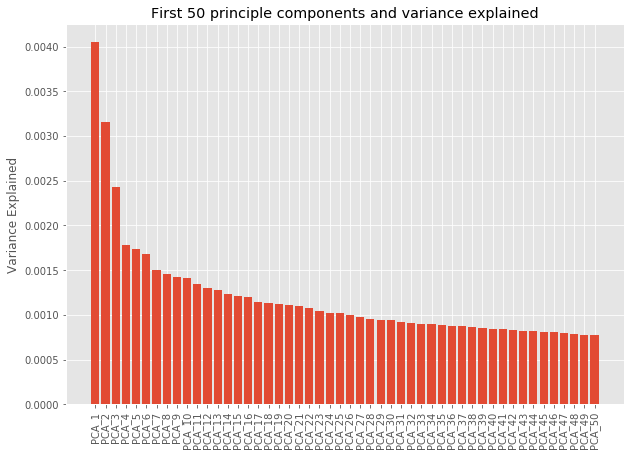

In [20]:
pca_range = np.arange(50)+1
pca_names = ['PCA_%s' %i for i in pca_range]
plt.figure(figsize = (10,7))
plt.bar(pca_range, pca.explained_variance_ratio_, align = 'center')
plt.xticks(pca_range, pca_names, rotation = 90)
plt.ylabel('Variance Explained')
plt.title('First 50 principle components and variance explained')
plt.show()

### Build the training model and compare the results

### Training without pca

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_vector, target_train)
model.score(train_vector, target_train)

0.8516965239801371

In [14]:
model.score(test_vector, target_test)

0.8502880542551069

### Training after pca for the feature vector

In [15]:
model = LogisticRegression()
model.fit(train_compoments, target_train)
model.score(train_compoments, target_train)

0.8296083977622729

In [16]:
model.score(test_compoments, target_test)

0.8311069262088305

### PCA could reduce the correlation between features, which will prevent the overfitting in the model. PCA also makes the model less understandable and decreases the accuracy. 